<a href="https://colab.research.google.com/github/pedrajAtharva/Projects_with_tf/blob/main/Skimlit_NLP_project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 // To build a NLP Model to make reading medical abstract easier. //
* Downloading pubmed 200k RCT
* preprocessing function
* Different level of embeddings
* multimodal model to take in different sources of data
* Finding most wrong prediction

In [1]:
 #Dataset - PubMed 200kRCT
 !git clone https://github.com/Franck-Dernoncourt/pubmed-rct
 !ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 35.18 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [2]:
#Using pubmed 20k (dev=validation set)
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [3]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [4]:
# Checking files in tareget directory
import os
filnames = [data_dir + filename for filename in os.listdir(data_dir)]
filnames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

In [5]:
#Visualizing the data
#Functions to read in all the lines of a target text file and return list of strings of file
def get_lines(filename):
  with open(filename, "r") as f:
    return f.readlines() #readlines will written the text as list

In [6]:
train_lines = get_lines(data_dir + "train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

Representing the data in the form of dictionary for each id
For ex -
'''  
[{'line_number' : 0
  'target' : 'BACKGROUND'
  'text' : '-------------------------'
  'total_lines_in_abstract':--- }
 ....]
 '''

In [7]:

def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [8]:
#Lets try the function
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 634 ms, sys: 141 ms, total: 775 ms
Wall time: 901 ms


(180040, 30212, 30135)

In [9]:
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [10]:
# Turning into dataframe for visualizing
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [11]:
# Labels in training data
train_df.target.value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


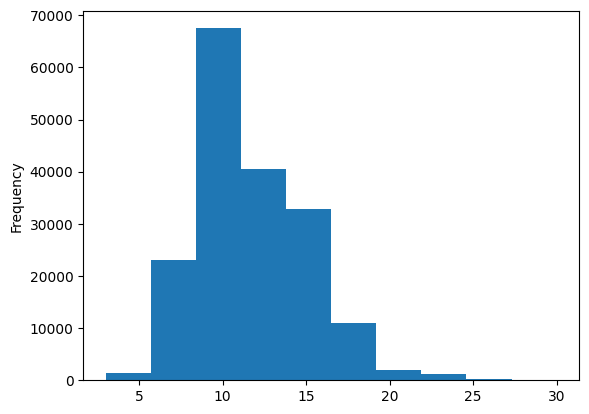

In [12]:
# Frequency of lines in different abstracts
train_df.total_lines.plot.hist();

In [13]:
#Convert abstract text into list
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [14]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [15]:
#turning labels into numerical data

#One hot encoding
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output = False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))
train_labels_one_hot


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [16]:
#Labels as another encoded labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [17]:
#Reverse engineering to see labels as encoded labels
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

**Models**
* 0 - Naive base with tf-idf
* 1 - Conv1D with token embeddings
* 2 - Tf hub pretrained feature extractor
* 3 - Conv1D with character embeddings
* 4 - 2 + 3
* 5 - 2 + 3 + positional embeddings

> Add blockquote



In [18]:
#0 - baseline model - TF-IDF multinomial Naive Bayes classifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the pipeline
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [19]:
#Evaluation on validation set
model_0.score(X=val_sentences,
                 y=val_labels_encoded)

0.7218323844829869

In [20]:
#Predictions using baseline
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [21]:
#Using pred created function to cal accuracy, precision, recall and f-1 score
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2025-08-11 06:22:17--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2025-08-11 06:22:17 (18.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [22]:
from helper_functions import calculate_results

In [23]:
baseline_results = calculate_results(y_true = val_labels_encoded,
                                     y_pred = baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [24]:
#Prepare the input data [text] - vectorization and embedding layers
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers


In [25]:
# How long is the sentence
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

np.float64(26.338269273494777)

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

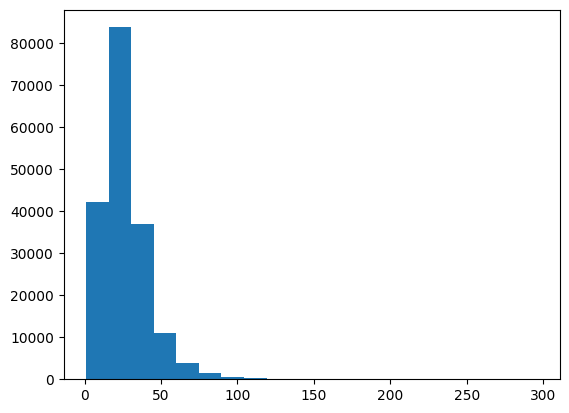

In [26]:
#Distribution
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20)

In [27]:
#How long sentences length covers 95%
output_seq_length =int(np.percentile(sent_lens, 95))
output_seq_length

55

In [28]:
# Max seq length in training length
max(sent_lens)

296

In [29]:
# text vectorizer layer
max_tokens = 68000

from tensorflow.keras.layers import TextVectorization
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=output_seq_length)

In [30]:
# Fitting text vectorization to training data
text_vectorizer.adapt(train_sentences)

Random sentence Text vectorization for learning purpose

In [31]:
#Viewing the textVectorizer
import random
target_sentence = random.choice(train_sentences)
print(f"text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

text:
a group of @ women with unexplained secondary recurrent miscarriage and at least four miscarriages .

Length of text: 16

Vectorized text: [[    8    13     4    90     7  7422   151   857  6911     3    15   322
    297 18373     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [32]:
#Words in Vocab are
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Total words in vocab are: {len(rct_20k_text_vocab)}")
print(f"Most common words : {rct_20k_text_vocab[:10]}")
print(f"Least common words : {rct_20k_text_vocab[-10:]}")

Total words in vocab are: 64841
Most common words : ['', '[UNK]', np.str_('the'), np.str_('and'), np.str_('of'), np.str_('in'), np.str_('to'), np.str_('with'), np.str_('a'), np.str_('were')]
Least common words : [np.str_('aarm'), np.str_('aaqol'), np.str_('aaq'), np.str_('aanhui'), np.str_('aana'), np.str_('aainduced'), np.str_('aaigroup'), np.str_('aachener'), np.str_('aachen'), np.str_('aaacp')]


In [33]:
#Get config of text Vectorizer layer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

In [34]:
#Creating embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                                output_dim=128,
                                mask_zero=True,
                                name="token_embedding")

In [35]:
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization(before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Shape of embedding:\n {embedded_sentence.shape}")

Sentence before vectorization:
 a group of @ women with unexplained secondary recurrent miscarriage and at least four miscarriages .

Sentence after vectorization(before embedding):
 [[    8    13     4    90     7  7422   151   857  6911     3    15   322
    297 18373     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
 [[[ 0.00594084 -0.03763043 -0.03630947 ...  0.02436144 -0.0305331
    0.03361448]
  [-0.0201125  -0.01569375  0.02475575 ... -0.02830364 -0.04795836
   -0.03459605]
  [ 0.02886755 -0.01000702  0.03730435 ...  0.00956919 -0.03140863
    0.01254244]
  ...
  [ 0.02785391 -0.00139364  0.03268084 ...  0.01033386  0.04510694
    0.01327248]
  [ 0.02785391 -0.00139364  0.03268084 ...  0.01033386  0.04510694
    0.01327248]
  [ 0.02785391 -0.00139364 

#Creating dataset#

In [36]:
# Turning the data into TF datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [37]:
# Turning dataset into prefeched dataset
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [38]:
#Model 1 - Conv 1D with token embeddings
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(5, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

#Compile
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [39]:
model_1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 55)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_embedding (Embedding)     │ (None, 55, 128)        │     8,299,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 55, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,340,997 (31.82 MB)

 Trainable params: 8,340,997 (31.82 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [41]:
len(train_dataset)

5627

In [42]:
(len(train_dataset)*10)/100  #Will consider passsing this value because it will speed up the processs

562.7

In [43]:
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),#We only want our model to look ast 10 per of batches
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*(len(valid_dataset)))) # We only want our model to validate on 10 per of batches

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 51s 88ms/step - accuracy: 0.5242 - loss: 1.1609 - val_accuracy: 0.7380 - val_loss: 0.6896
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 82s 146ms/step - accuracy: 0.7438 - loss: 0.6849 - val_accuracy: 0.7719 - val_loss: 0.6347
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 82s 146ms/step - accuracy: 0.7705 - loss: 0.6261 - val_accuracy: 0.7829 - val_loss: 0.6009


In [44]:
#Evaluate on whole validation dataset
model_1.evaluate(valid_dataset) #On 945 batches

945/945 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7851 - loss: 0.5985


[0.6006590723991394, 0.7857804894447327]

In [45]:
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step


(array([[4.1377378e-01, 1.6927166e-01, 1.0322910e-01, 2.8055444e-01,
         3.3170879e-02],
        [4.0012008e-01, 3.2989156e-01, 9.0747690e-03, 2.5103262e-01,
         9.8808361e-03],
        [1.5983856e-01, 6.4741061e-03, 2.5932146e-03, 8.3104557e-01,
         4.8537229e-05],
        ...,
        [5.3591930e-06, 9.8766235e-04, 6.2793319e-04, 2.1506198e-06,
         9.9837685e-01],
        [4.1256499e-02, 4.2372018e-01, 8.9486673e-02, 4.5500100e-02,
         4.0003657e-01],
        [2.2028537e-01, 6.3173050e-01, 4.4351809e-02, 5.0568014e-02,
         5.3064410e-02]], dtype=float32),
 (30212, 5))

In [46]:
#COnvert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [47]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [48]:
#Cal model_1 results / Comparing the predicted val labels with the actual labels from the valid dataset
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.57804845756652,
 'precision': 0.7823129333194037,
 'recall': 0.7857804845756653,
 'f1': 0.7830236901867929}

In [49]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

So we beat baseline model with Conv1D token embedding model

In [50]:

# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [51]:
#Test out pretrained embedding on a random sentence
random_train_sentences = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentences}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentences])
print(f"Sentence after embedding:\n {use_embedded_sentence}")
print(f"Length of sentence embedding:\n {len(use_embedded_sentence[0])}")

Random sentence:
 chinese clinical trial registry ( trc-@ ) .
Sentence after embedding:
 [[-0.01153939  0.01449943 -0.02894766  0.00658926 -0.00402536 -0.05809567
  -0.05279424 -0.03636916 -0.00141894 -0.06490091  0.07275972  0.02263922
  -0.03981916 -0.01192205  0.06095181  0.02468892 -0.08249255 -0.028093
  -0.00754241  0.0266648  -0.08159989  0.02246276  0.01732438  0.03588985
  -0.03735805  0.04009715 -0.05391139  0.06545193 -0.02823086  0.069798
   0.0684733   0.0846017  -0.0087085   0.0471989   0.03225067 -0.04529833
  -0.07904244 -0.04625591 -0.02317036 -0.02766864 -0.01648819 -0.05502114
   0.03867714 -0.02844602  0.01494832 -0.01696858  0.04211951  0.01425851
  -0.07107989  0.05192415 -0.04328008 -0.00942357 -0.04156233  0.00714475
   0.07327019  0.06131945  0.07983305  0.04368552  0.01936084  0.04869984
  -0.06510411 -0.0012933   0.00545309 -0.01241949  0.0621987  -0.00300668
   0.0068422   0.00483    -0.04512061  0.05871104  0.03701692 -0.04280857
   0.07057977  0.02566934  

In [52]:
# Define a custom Keras Layer to wrap the TensorFlow Hub embedding layer
class HubEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, hub_layer, **kwargs):
        super().__init__(**kwargs)
        self.hub_layer = hub_layer

    def call(self, inputs):
        return self.hub_layer(inputs)

# Model Building with the custom layer
inputs = layers.Input(shape=(), dtype=tf.string) # Input shape for scalar string
custom_embedding = HubEmbeddingLayer(tf_hub_embedding_layer)(inputs) # Use the custom layer
x = layers.Dense(128, activation="relu")(custom_embedding)
outputs = layers.Dense(5, activation="softmax")(x)
model_2 = tf.keras.Model(inputs=inputs,
                                outputs=outputs,
                                name="Model_2_use_feature_extractor_custom")

# Compile the custom model
model_2.compile(loss="categorical_crossentropy",
                       optimizer=tf.keras.optimizers.Adam(),
                       metrics=["accuracy"])

model_2.summary()

Model: "Model_2_use_feature_extractor_custom"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hub_embedding_layer             │ (None, 512)            │             0 │
│ (HubEmbeddingLayer)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,309 (259.02 KB)

 Trainable params: 66,309 (259.02 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
#Fit the model_2
history_model_2 = model_2.fit(train_dataset,
                              epochs = 3,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.5821 - loss: 1.0902 - val_accuracy: 0.6878 - val_loss: 0.7953
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.7025 - loss: 0.7705 - val_accuracy: 0.7068 - val_loss: 0.7531
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.7133 - loss: 0.7531 - val_accuracy: 0.7158 - val_loss: 0.7382


In [54]:
#Evaluate on validataset
model_2.evaluate(valid_dataset)#945 batches

945/945 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.7149 - loss: 0.7388


[0.7407848238945007, 0.7140209078788757]

In [55]:
# Making pred probs
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step


array([[4.2808005e-01, 3.5801980e-01, 2.1712151e-03, 2.0447826e-01,
        7.2505861e-03],
       [3.2498693e-01, 5.2458370e-01, 2.9009797e-03, 1.4450611e-01,
        3.0221941e-03],
       [2.1942902e-01, 1.4964157e-01, 2.0252619e-02, 5.7255995e-01,
        3.8116835e-02],
       ...,
       [1.5982921e-03, 5.9961001e-03, 5.0980520e-02, 8.5725152e-04,
        9.4056791e-01],
       [4.4087116e-03, 5.0244153e-02, 2.0393546e-01, 1.4736356e-03,
        7.3993802e-01],
       [2.0425516e-01, 2.4072255e-01, 4.7481152e-01, 7.1433857e-03,
        7.3067419e-02]], dtype=float32)

In [56]:
# Converting the pred probs to labels
model_2_preds =tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [57]:
# Cal results from TF HUB embedding model on val set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.4020918840196,
 'precision': 0.7150635794015805,
 'recall': 0.7140209188401959,
 'f1': 0.7112254545838388}

In [58]:
baseline_results, model_1_results

({'accuracy': 72.1832384482987,
  'precision': 0.7186466952323352,
  'recall': 0.7218323844829869,
  'f1': 0.6989250353450294},
 {'accuracy': 78.57804845756652,
  'precision': 0.7823129333194037,
  'recall': 0.7857804845756653,
  'f1': 0.7830236901867929})

#Model-3 Conv1D with character embeddings
#Char level tokenization

In [59]:
#Function to seperate char from sentences
def split_chars(text):
  return " ".join(list(text))

In [60]:
#Split sequence level data splits into character level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [61]:
# What is the average char length
chars_lens = [len(sentence) for sentence in train_sentences]
mean_char_lens = np.mean(chars_lens)
mean_char_lens

np.float64(149.3662574983337)

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

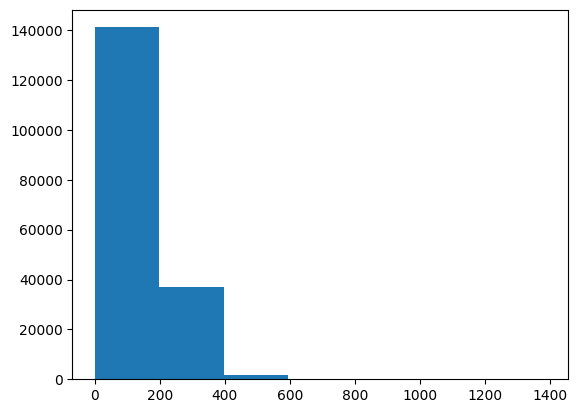

In [62]:
#Check the distribution at char level tokenization
import matplotlib.pyplot as plt
plt.hist(chars_lens, bins=7)

In [63]:
#Find what covers the 95 per of senq
output_seq_char_len = int(np.percentile(chars_lens, 95))
output_seq_char_len

290

In [64]:
#Get all keyboard chracters as we have to tokenize unique char
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [65]:
#Create char-level tokens with unique values
NUM_CHAR_TOKENS = len(alphabet) + 2 # 2 dor OOv and space
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    # standardize=None if you want to leave punctuation
                                    name="char_vectorizer")

In [66]:


#Adapting this to training charcter
char_vectorizer.adapt(train_chars)

In [67]:

#Checking the vocab
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in cahracter vocab: {len(char_vocab)}")
print(f"5 most common charcaters: {char_vocab[:5]}")
print(f"5 least common charcters: {char_vocab[-5:]}")

Number of different characters in cahracter vocab: 28
5 most common charcaters: ['', '[UNK]', np.str_('e'), np.str_('t'), np.str_('i')]
5 least common charcters: [np.str_('k'), np.str_('x'), np.str_('z'), np.str_('q'), np.str_('j')]


In [68]:


#Test the char vectorize
random_train_chars = random.choice(train_chars)
print(f"Random_sentence:\n {random_train_chars}")
print(f"length of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"Vectorized random_train_chars :\n{vectorized_chars}")
print(f"length of vectorized chars:\n {len(vectorized_chars[0])}")

Random_sentence:
 r e s i d e n t s   w i t h   a c c e s s   t o   t h e   m o d u l e s   w e r e   a l s o   s u r v e y e d   t o   a s s e s s   u s e   a n d   o b t a i n   f e e d b a c k   a b o u t   t h e   m o d u l e s   .
length of random_train_chars: 91
Vectorized random_train_chars :
[[ 8  2  9  4 10  2  6  3  9 20  4  3 13  5 11 11  2  9  9  3  7  3 13  2
  15  7 10 16 12  2  9 20  2  8  2  5 12  9  7  9 16  8 21  2 19  2 10  3
   7  5  9  9  2  9  9 16  9  2  5  6 10  7 22  3  5  4  6 17  2  2 10 22
   5 11 23  5 22  7 16  3  3 13  2 15  7 10 16 12  2  9  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  

In [69]:
#  create char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim=25,#Size of char embedding in paper
                              mask_zero=True,
                              name="char_embed")

In [70]:
#Testing char embedding
print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n {char_embed_example}")
print(f"Char embedding shape: {char_embed_example.shape}")

Charified text:
 r e s i d e n t s   w i t h   a c c e s s   t o   t h e   m o d u l e s   w e r e   a l s o   s u r v e y e d   t o   a s s e s s   u s e   a n d   o b t a i n   f e e d b a c k   a b o u t   t h e   m o d u l e s   .

Embedded chars (after vectorization and embedding):
 [[[ 0.03778959 -0.01955806  0.00033908 ...  0.04861316 -0.01490623
   -0.03700735]
  [ 0.04041353 -0.00490154 -0.00185547 ... -0.01172869  0.0441928
    0.02423337]
  [ 0.0254197  -0.01384814 -0.01960084 ...  0.00214338  0.0413863
    0.01201553]
  ...
  [-0.00660839  0.03711318  0.02733734 ...  0.01919914 -0.03291708
   -0.02825042]
  [-0.00660839  0.03711318  0.02733734 ...  0.01919914 -0.03291708
   -0.02825042]
  [-0.00660839  0.03711318  0.02733734 ...  0.01919914 -0.03291708
   -0.02825042]]]
Char embedding shape: (1, 290, 25)


In [71]:
len(random_train_chars)

217

In [72]:
#Building Conv1D with char level token embeddings
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name ="model_3_char_embeddings")

#Compile
model_3.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

#Summary
model_3.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "model_3_char_embeddings"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ char_vectorizer                 │ (None, 290)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ char_embed (Embedding)          │ (None, 290, 25)        │           700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 290, 64)        │         8,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,089 (35.50 KB)

 Trainable params: 9,089 (35.50 KB)

 Non-trainable params: 0 (0.00 B)

In [73]:
#Create dataset for char level
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [74]:
#Fit the model
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch = int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))


Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.4301 - loss: 1.3838 - val_accuracy: 0.5841 - val_loss: 1.0390
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - accuracy: 0.5905 - loss: 1.0256 - val_accuracy: 0.6253 - val_loss: 0.9518
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.6307 - loss: 0.9429 - val_accuracy: 0.6589 - val_loss: 0.8867


In [75]:
#Make predictions with char model
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step


array([[0.14866188, 0.33903453, 0.12934378, 0.26925528, 0.11370454],
       [0.1991292 , 0.4887332 , 0.03396338, 0.19792295, 0.08025126],
       [0.11237936, 0.34947303, 0.11081211, 0.36516947, 0.06216602],
       ...,
       [0.07303344, 0.08895117, 0.15590139, 0.0879278 , 0.5941862 ],
       [0.03152116, 0.09788031, 0.3959287 , 0.06623399, 0.4084358 ],
       [0.4915307 , 0.2665693 , 0.13632715, 0.07952411, 0.02604873]],
      dtype=float32)

In [76]:
#Convert pred probs to class labels
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 0])>

In [77]:
#Cal results for conv1D model chars
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 65.08672050840725,
 'precision': 0.6468810810544265,
 'recall': 0.6508672050840726,
 'f1': 0.6405944762496771}

In [78]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

#Model 4 : Combining pretrained token embeddings + character embeddings
 Create a token level embedding model and then character level embedding model and then concate both with (layers.concatenate)

In [79]:
#Setup token level model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_inputs")
token_embeddings = HubEmbeddingLayer(tf_hub_embedding_layer)(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

#Setup charlevel embedding model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

#Concatenate both models
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

#Create dropout and output layers
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(1238, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

#Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="Model_4_token_char_hybrid_model")


In [80]:
#Summary of model_4
model_4.summary()

Model: "Model_4_token_char_hybrid_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ char_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_inputs        │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_vectorizer     │ (None, 290)       │          0 │ char_input[0][0]  │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hub_embedding_laye… │ (None, 512)       │          0 │ token_inputs[0][… │
│ (HubEmbeddingLayer) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_embed          │ (None, 290, 25)   │        700 │ char_vectorizer[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 290)       │          0 │ char_vectorizer[… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     65,664 │ hub_embedding_la… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 48)        │      9,600 │ char_embed[1][0], │
│ (Bidirectional)     │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_char_hybrid   │ (None, 176)       │          0 │ dense_4[0][0],    │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 176)       │          0 │ token_char_hybri… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1238)      │    219,126 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 1238)      │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 5)         │      6,195 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 301,285 (1.15 MB)

 Trainable params: 301,285 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

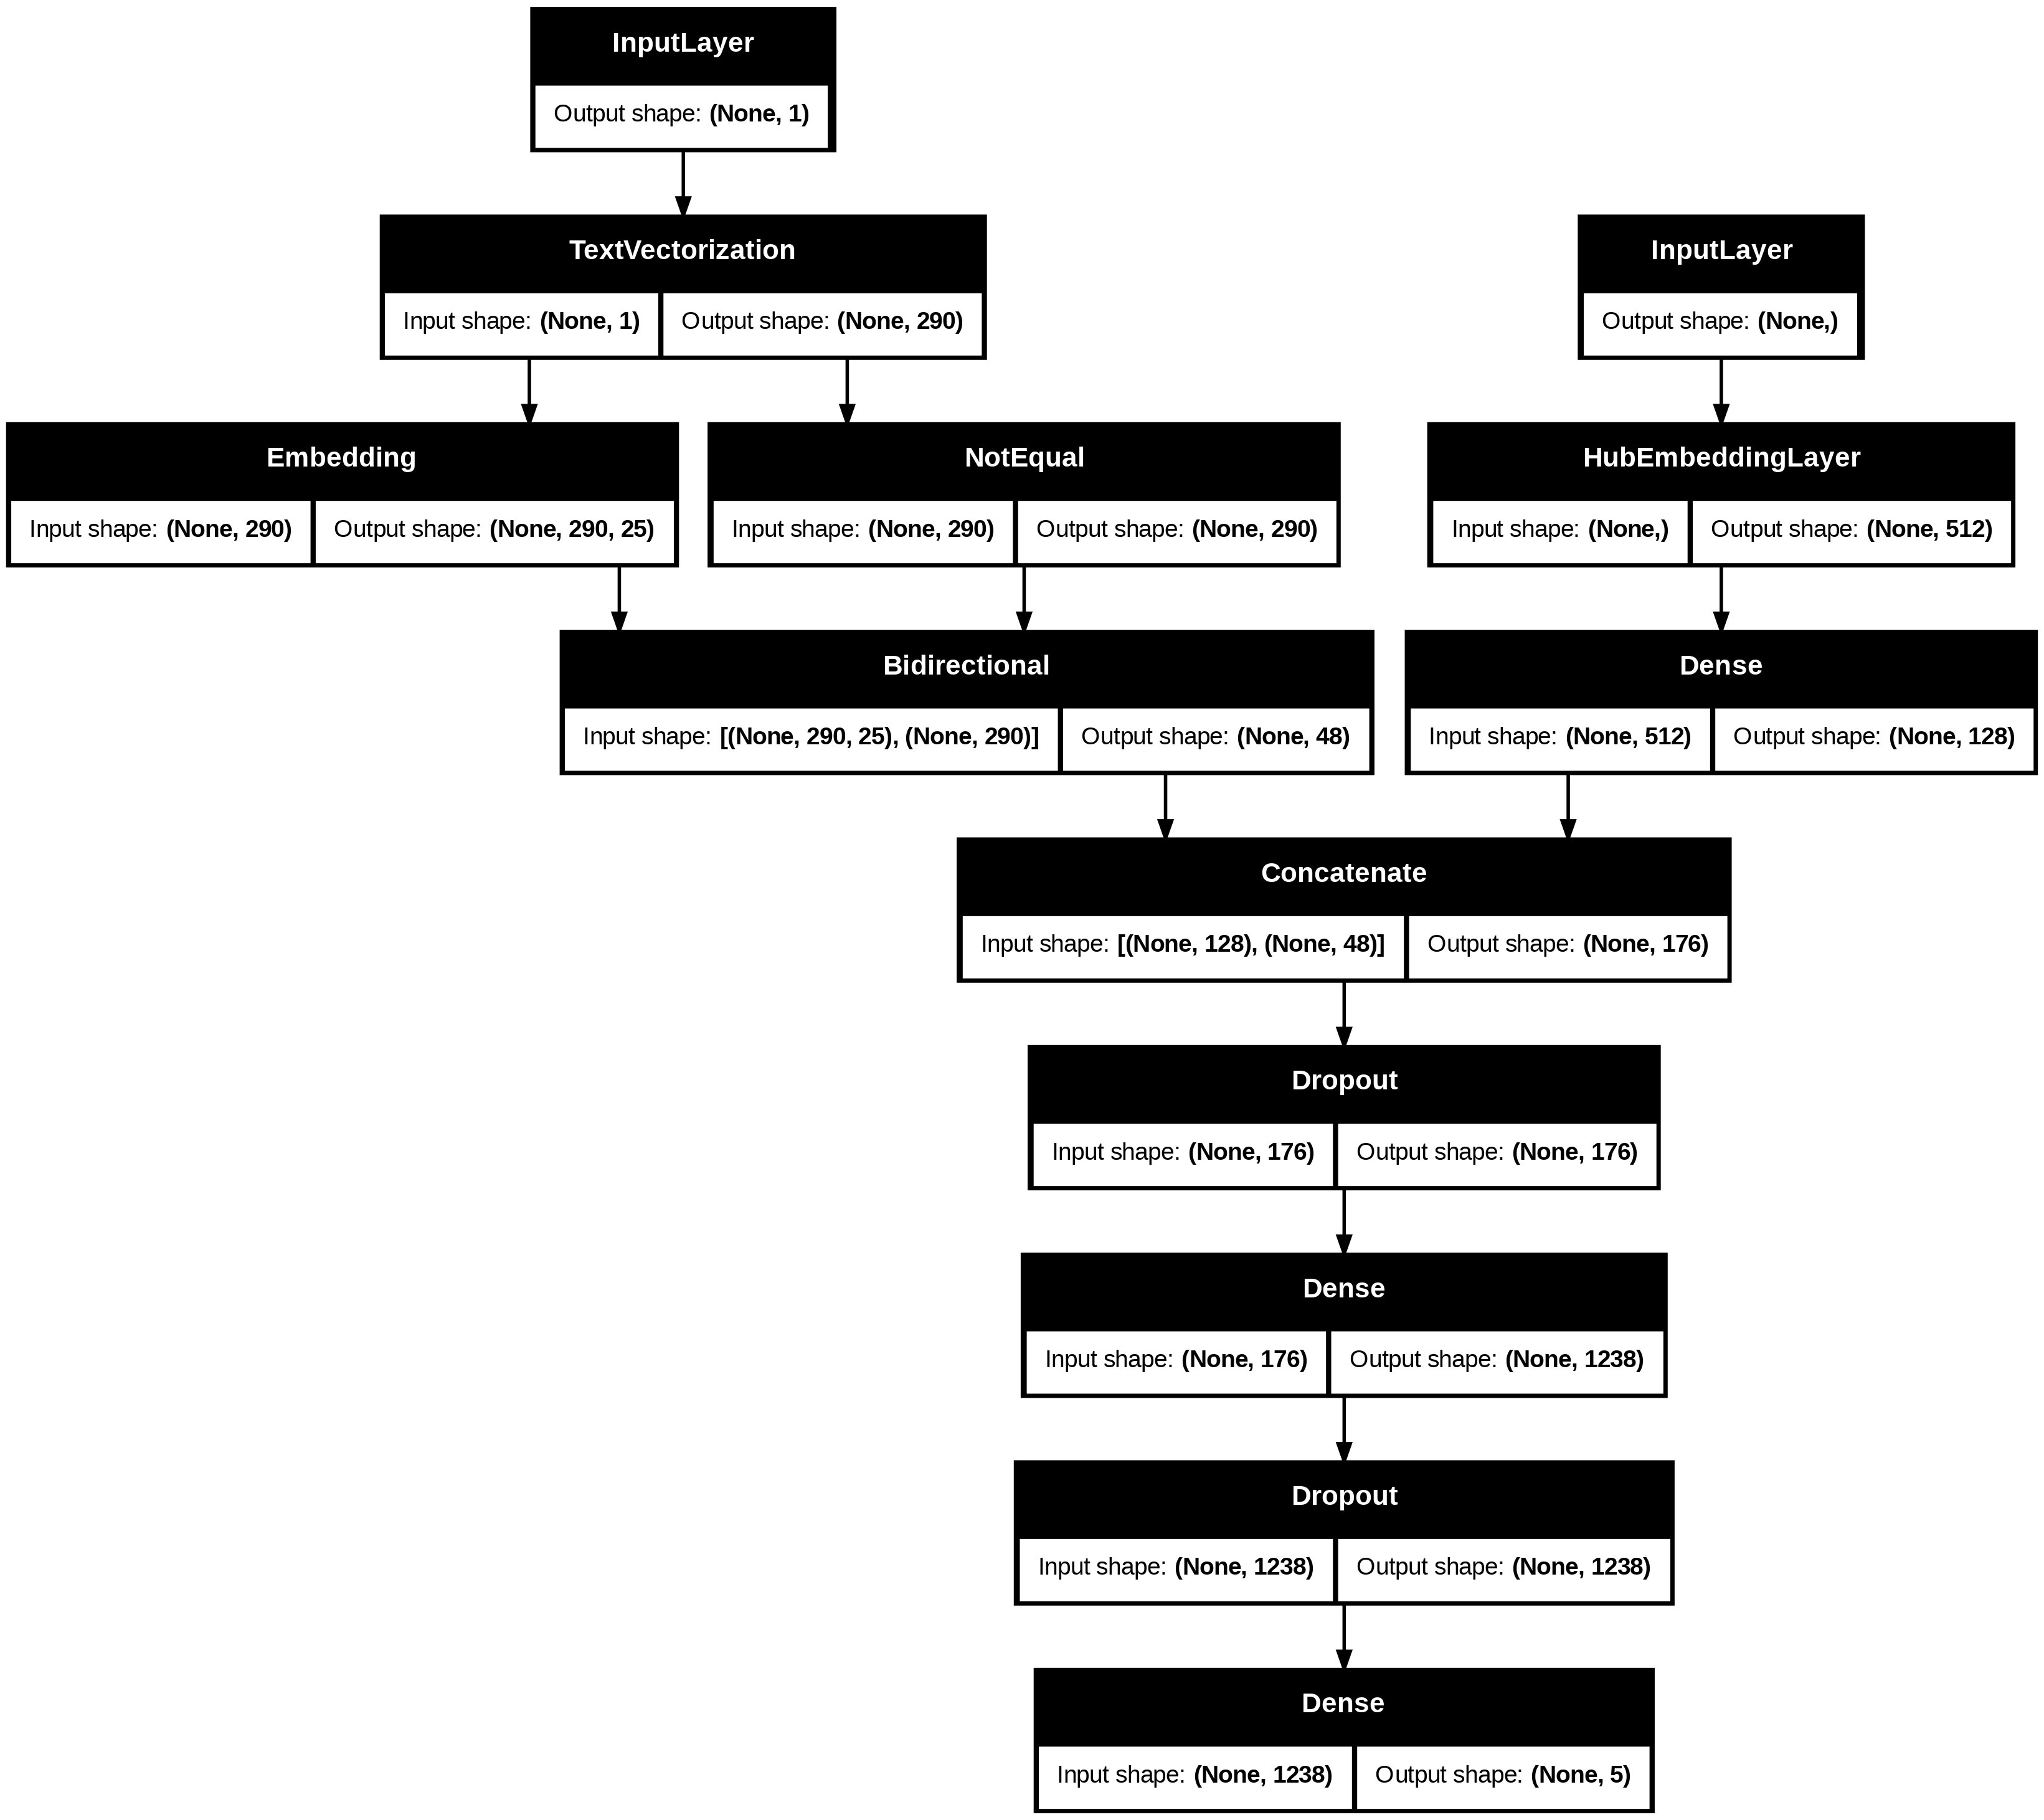

In [81]:
#Plot hybrid token and char model
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [82]:
#Compile the hybrid model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [83]:
#Creating data loaders for model_4 hybrid model
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip(train_char_token_data, train_char_token_labels)


#Prefetch and batch train_data

train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [84]:
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip(val_char_token_data, val_char_token_labels)


# Prefetch and batch val_data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [85]:
#Checking both train and val prefetched dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

While creating the dataset for a hybrid model the dataset we are passing should be in correct order as model is constructed otherwise model will get confused (will use token level character on model1 and vice-versa)

In [86]:
#Fitting the model
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 191s 326ms/step - accuracy: 0.5612 - loss: 1.0732 - val_accuracy: 0.7118 - val_loss: 0.7439
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 185s 329ms/step - accuracy: 0.6996 - loss: 0.7794 - val_accuracy: 0.7377 - val_loss: 0.7015
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 203s 361ms/step - accuracy: 0.7094 - loss: 0.7530 - val_accuracy: 0.7497 - val_loss: 0.6716


In [87]:
#Evaluate on whole val dataset
model_4.evaluate(val_char_token_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 66s 70ms/step - accuracy: 0.7421 - loss: 0.6789


[0.67982417345047, 0.7422216534614563]

In [88]:
#MAake pred probs
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 62s 65ms/step


array([[4.96083081e-01, 2.10807249e-01, 1.09565002e-03, 2.88689256e-01,
        3.32459388e-03],
       [3.84981692e-01, 4.44740504e-01, 1.84882153e-03, 1.67071968e-01,
        1.35704433e-03],
       [3.54266614e-01, 1.29461318e-01, 3.47151719e-02, 4.60575521e-01,
        2.09813956e-02],
       ...,
       [8.38001783e-04, 6.33941730e-03, 8.47502798e-02, 4.16439987e-04,
        9.07655835e-01],
       [8.08714516e-03, 5.85095100e-02, 2.95636058e-01, 4.63597197e-03,
        6.33131325e-01],
       [2.84182340e-01, 5.53743362e-01, 1.10054456e-01, 3.60260829e-02,
        1.59938503e-02]], dtype=float32)

In [89]:
# Pred_probs to pred labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [90]:
#get results of token_char_hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 74.22216337878989,
 'precision': 0.7452961931999785,
 'recall': 0.7422216337878988,
 'f1': 0.7407044903300208}

In [91]:
model_1_results

{'accuracy': 78.57804845756652,
 'precision': 0.7823129333194037,
 'recall': 0.7857804845756653,
 'f1': 0.7830236901867929}

Still not able to beat model_1


#Model5 - Transfer learning with pretrained token embeddings + char embeddings + positional embeddings

In [92]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [93]:
###Creating positional embeddings

# Checking different line numbers
train_df["line_number"].value_counts()

,count
line_number,
0,15000
1,15000
2,15000
3,15000
4,14992
5,14949
6,14758
7,14279
8,13346


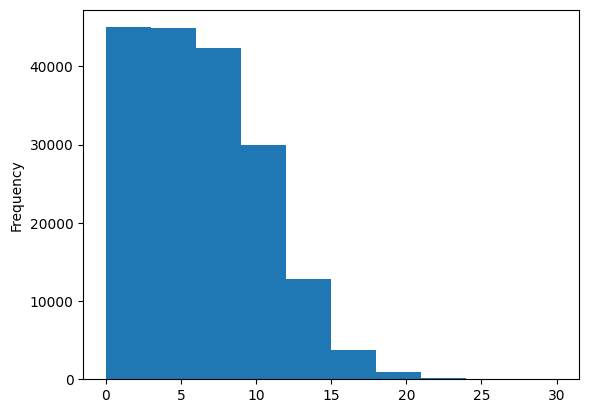

In [94]:
# Checking distribution of line_numbers
train_df.line_number.plot.hist();

In [95]:
#Creating one-hot-encoded tensors
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

In [96]:
# Now total line feature column

#How many lines are there
train_df["total_lines"].value_counts()

,count
total_lines,
11,24468
10,23639
12,22113
9,19400
13,18438
14,14610
8,12285
15,10768
7,7464


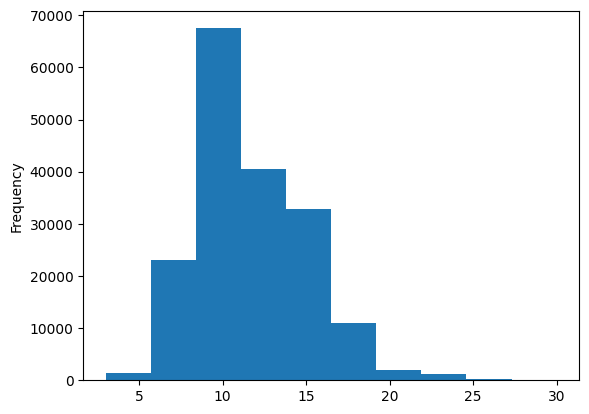

In [97]:
#Check the distribution
train_df.total_lines.plot.hist();

In [98]:
#Coverage of total_lineson 98percent = 20
np.percentile(train_df.total_lines, 98)

np.float64(20.0)

In [99]:
# one_hot encode for total_lines
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)
train_total_lines_one_hot[:10], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

#Building Tribrid
1.token_level,
2.char_level,
3.model_for_line_number,
4.model_for_total_lines,
5.Combine_output of 1 and 2, (Concat)
6.Combine_outputs of 3,4,5 (Concat)
7. Create output layer for tribrid embedding and output label prob
8. Combine input of 1,2,3,4 and output 7 into tf.keras.Model


In [106]:
#token input
token_input = layers.Input(shape=[], dtype="string", name="token_input")
token_embeddings = HubEmbeddingLayer(tf_hub_embedding_layer)(token_input)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_models = tf.keras.Model(inputs=token_inputs,
                              outputs=token_outputs)


#Char input
char_input = layers.Input(shape=(1, ), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

#Line number model
line_number_inputs = layers.Input(shape=(15, ), dtype=tf.float32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs = line_number_inputs,
                                   outputs = x)

#Total lines model
total_lines_inputs = layers.Input(shape=(20, ), dtype=tf.float32, name="total_lines_inputs")
y = layers.Dense(32, activation = "relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs = total_lines_inputs,
                                  outputs = y)

#Combining outputs of token and char models
combined_embeddings = layers.Concatenate(name = "char_token_hybrid_embeddings")([token_model.output,
                                                                               char_model.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

#Combine positional embeddings with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name = "char_token_positional_embeddings")([line_number_model.output,
                                                                                    total_lines_model.output,
                                                                                    z])
#Create tribrid model output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer_tribrid")(tribrid_embeddings)

#Put together model with all the inputs
model_5 = tf.keras.Model(inputs = [line_number_model.input,
                                   total_lines_model.input,
                                   token_model.input,
                                   char_model.input],
                         outputs=output_layer,
                         nmae = "tribrid_embedding_model")

In [107]:
#Summary of model_5 - TRIBRID
model_5.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ char_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_inputs        │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_vectorizer     │ (None, 290)       │          0 │ char_input[0][0]  │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hub_embedding_laye… │ (None, 512)       │          0 │ token_inputs[0][… │
│ (HubEmbeddingLayer) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_embed          │ (None, 290, 25)   │        700 │ char_vectorizer[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_3         │ (None, 290)       │          0 │ char_vectorizer[… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     65,664 │ hub_embedding_la… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 48)        │      9,600 │ char_embed[2][0], │
│ (Bidirectional)     │                   │            │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_token_hybrid_… │ (None, 176)       │          0 │ dense_4[0][0],    │
│ (Concatenate)       │                   │            │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ line_number_input   │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ total_lines_inputs  │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 256)       │     45,312 │ char_token_hybri… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 32)        │        512 │ line_number_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 32)        │        672 │ total_lines_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_token_positio… │ (None, 320)       │          0 │ dense_9[0][0],    │
│ (Concatenate)       │                   │            │ dense_10[0][0],   │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer_tribr… │ (None, 5)         │      1,605 │ char_token_posit… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 124,065 (484.63 KB)

 Trainable params: 124,065 (484.63 KB)

 Non-trainable params: 0 (0.00 B)

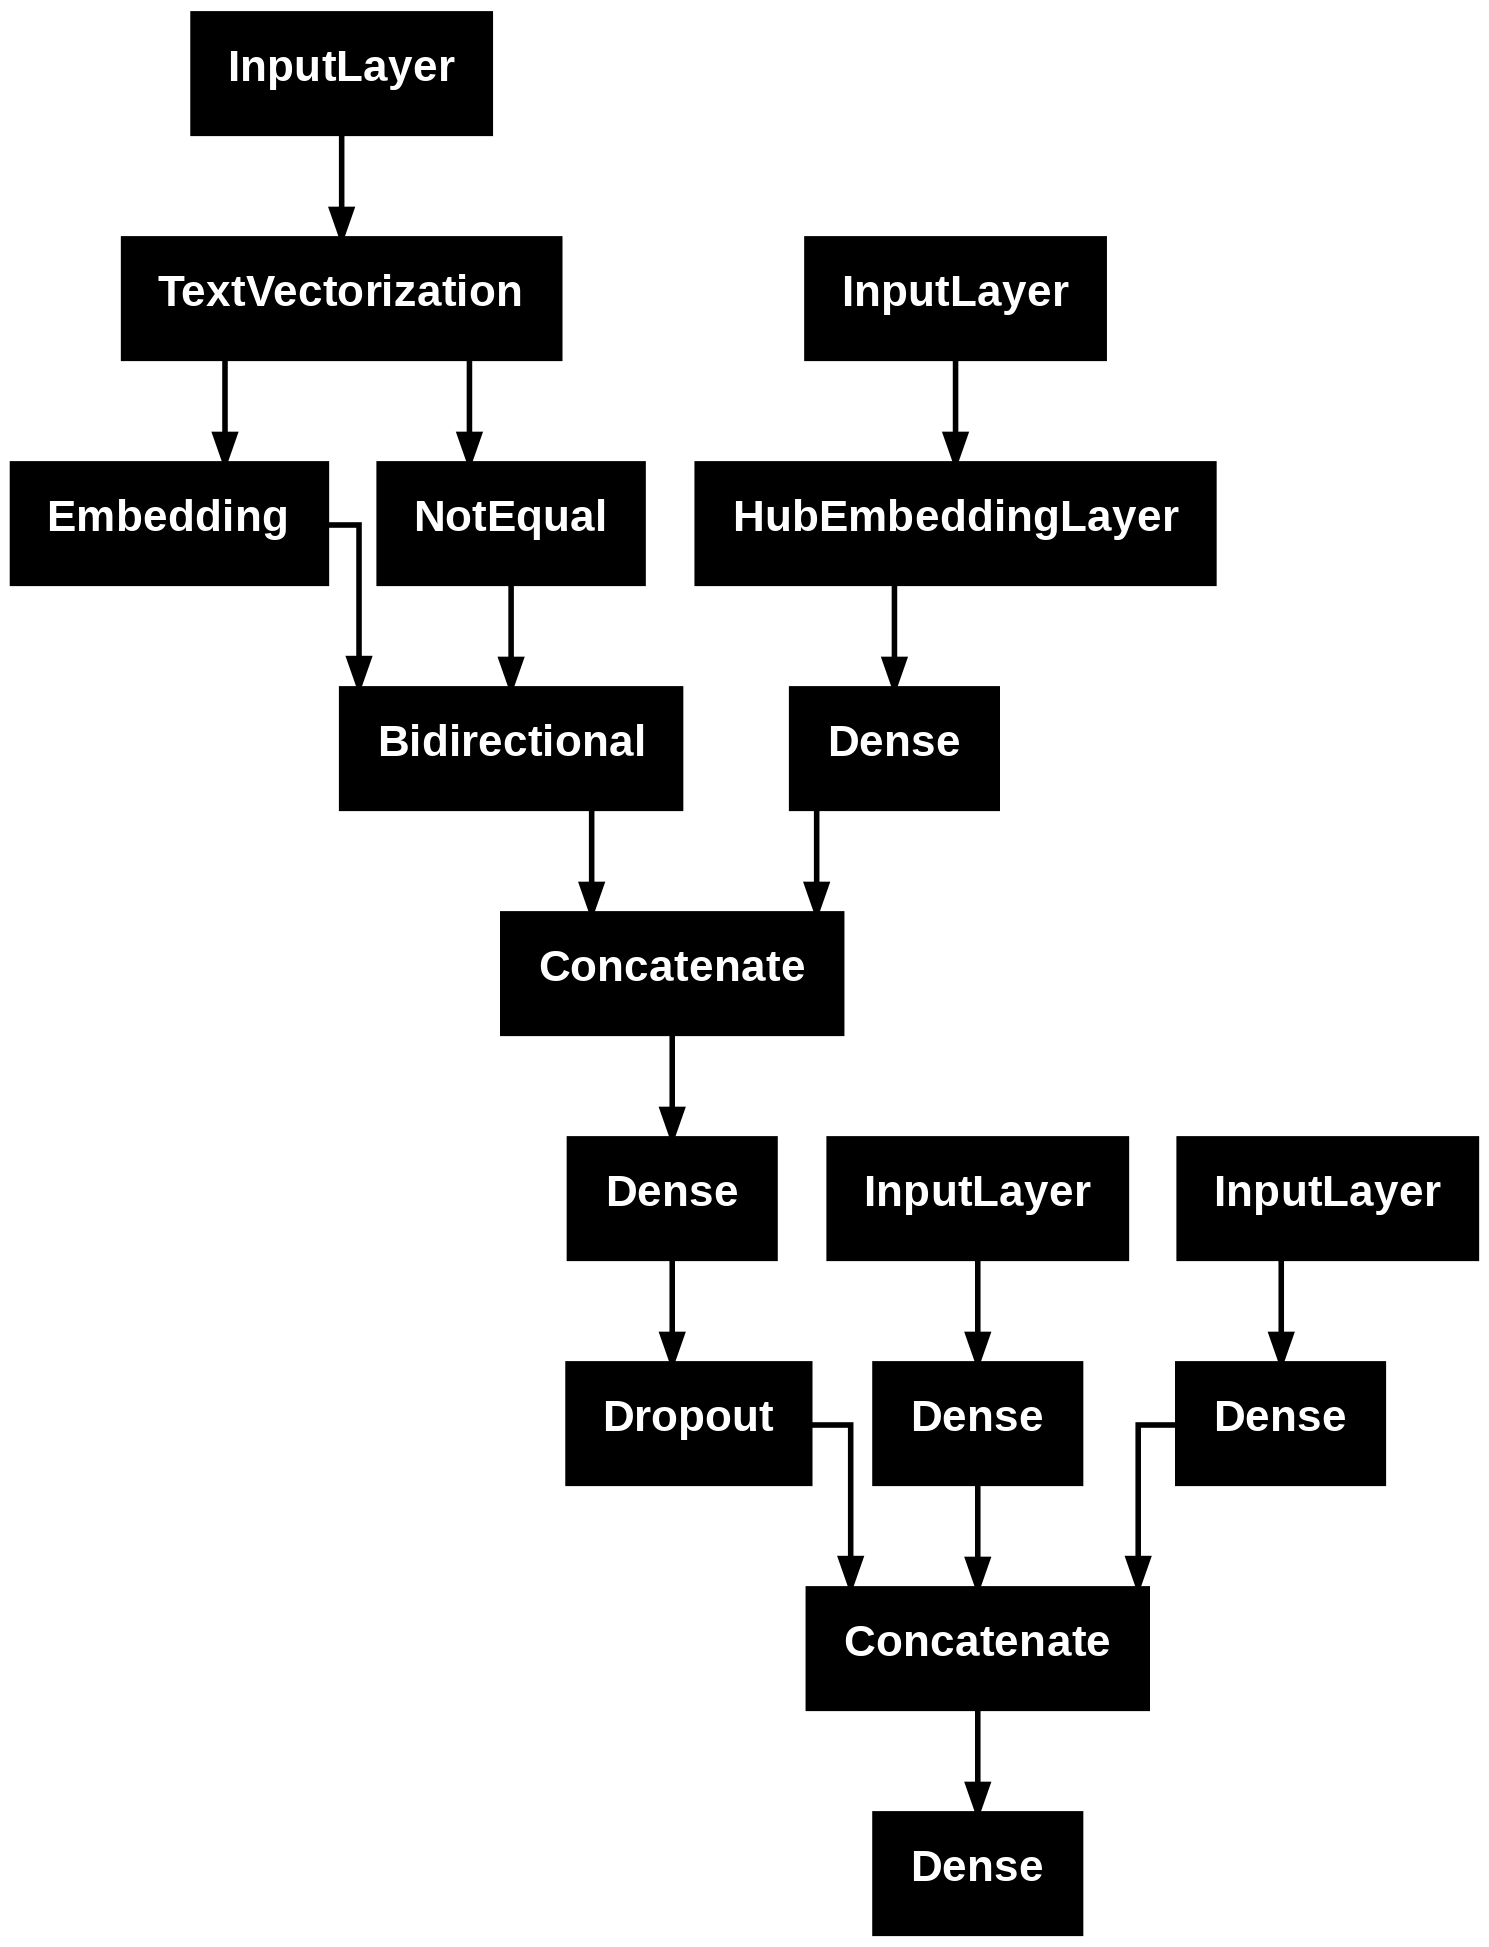

In [108]:
#Plot model_5
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [109]:
#Compile token, char and positional_embedding model - TRIBRID model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [111]:
#Creating dataset for Tribrid model

#Create training and validation datsets (with all kinds of inputs )

#Training
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data,
                                                 train_char_token_pos_labels))

train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


#Validation
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)

val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data,
                                                  val_char_token_pos_labels))

val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [112]:
#Checking input shape
train_char_token_pos_dataset, val_char_token_pos_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [115]:
#Fitting the TRIBRID model

history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch = int(0.1*len(train_char_token_pos_dataset)),
                              epochs=3,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1*len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 258s 446ms/step - accuracy: 0.6870 - loss: 1.1539 - val_accuracy: 0.8115 - val_loss: 0.9685
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 260s 463ms/step - accuracy: 0.8246 - loss: 0.9559 - val_accuracy: 0.8314 - val_loss: 0.9397
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 204s 363ms/step - accuracy: 0.8317 - loss: 0.9395 - val_accuracy: 0.8351 - val_loss: 0.9308


In [116]:
#Make prediction with TRIBRID model
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose=1)
model_5_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 85s 89ms/step


array([[0.5139867 , 0.11654747, 0.01022737, 0.33991402, 0.01932431],
       [0.5974612 , 0.09390163, 0.04130309, 0.25700882, 0.01032516],
       [0.29378223, 0.11207632, 0.12904148, 0.39894938, 0.06615056],
       ...,
       [0.03014829, 0.09641342, 0.03496762, 0.02880836, 0.80966234],
       [0.02881628, 0.27421346, 0.07384007, 0.0256453 , 0.5974849 ],
       [0.21064676, 0.66892046, 0.04568742, 0.03686181, 0.03788359]],
      dtype=float32)

In [117]:
#Convert pred probs to pred labels
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [118]:
#Cal results for TRIBRID model
model_5_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_5_preds)
model_5_results

{'accuracy': 83.86402753872633,
 'precision': 0.8380020705829135,
 'recall': 0.8386402753872634,
 'f1': 0.8372787948989332}

In [119]:
#Compare all models results
all_model_results = pd.DataFrame({"model_0_baseline" : baseline_results,
                                  "model_1_custom_token_embeddings" : model_1_results,
                                  "model_2_pretrained_token_embedings" : model_2_results,
                                  "model_3_custom_char_embeddings" : model_3_results,
                                  "model_4_hybrid_char_token_embeddings" : model_4_results,
                                  "model_5_Tribrid_char_token_pos_embeddings" : model_5_results})


all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embeddings,78.578048,0.782313,0.785780,0.783024
model_2_pretrained_token_embedings,71.402092,0.715064,0.714021,0.711225
model_3_custom_char_embeddings,65.086721,0.646881,0.650867,0.640594
model_4_hybrid_char_token_embeddings,74.222163,0.745296,0.742222,0.740704
model_5_Tribrid_char_token_pos_embeddings,83.864028,0.838002,0.838640,0.837279


In [120]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

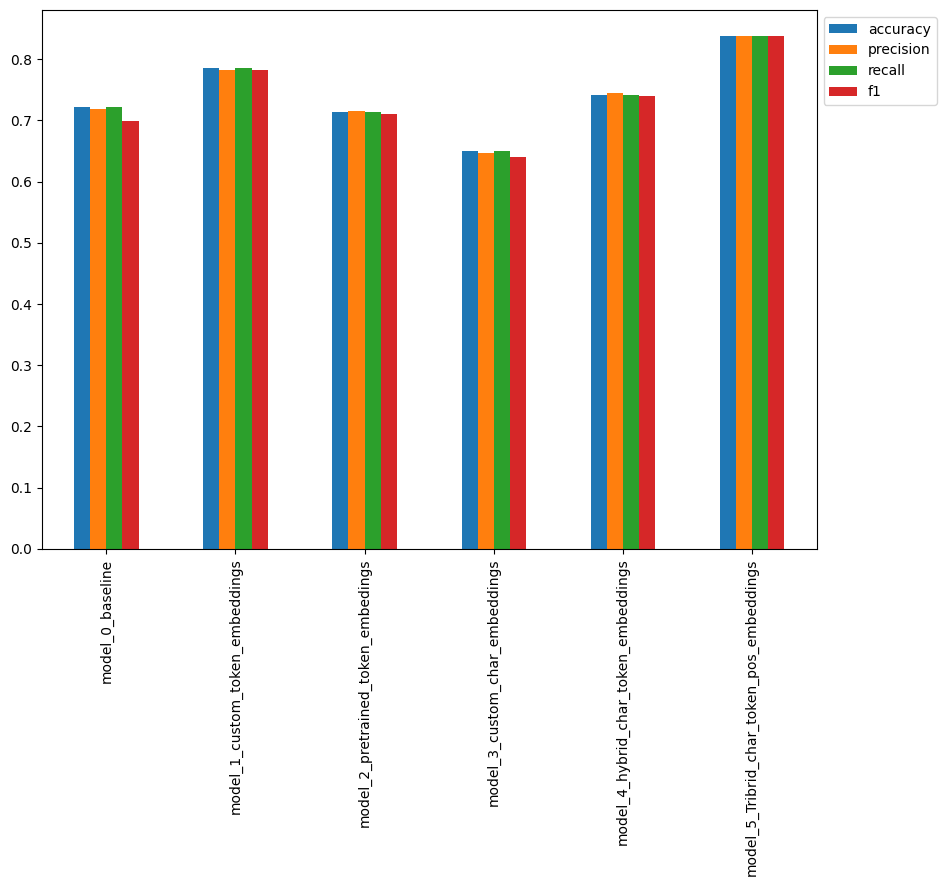

In [121]:
#Plot and compare all model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

<Axes: >

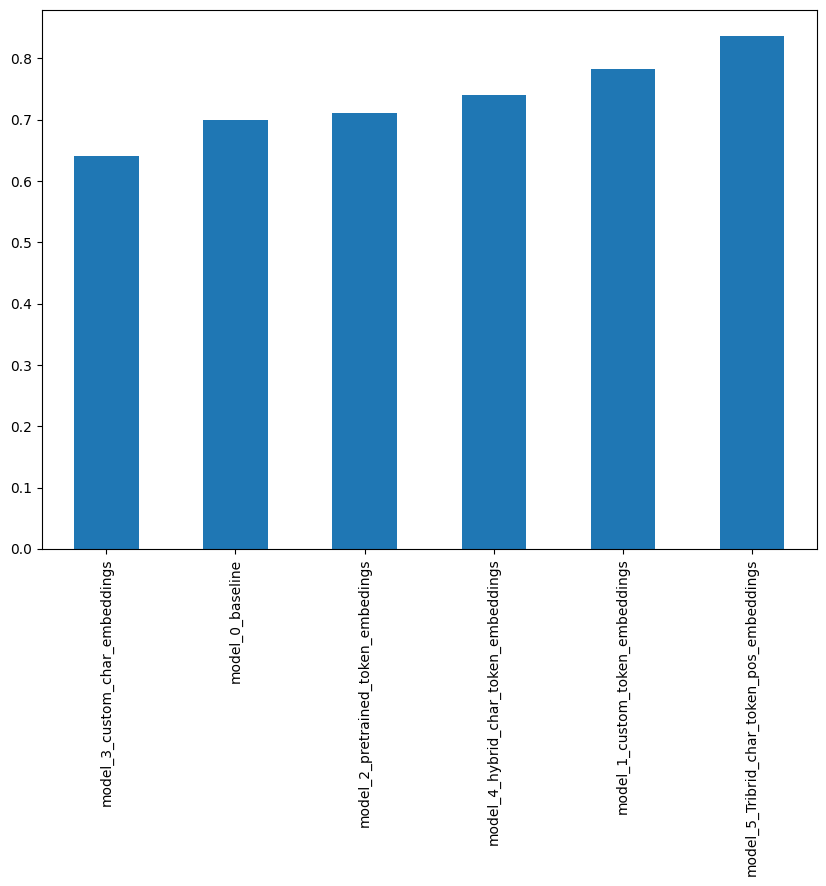

In [122]:
#Sor models results by f1 scores
all_model_results.sort_values("f1", ascending=True)["f1"].plot(kind="bar", figsize=(10, 7))

In [130]:

# Save the model
model_5.save('skimlit_tribrid_model.keras')


#Loading the model
loaded_model = tf.keras.models.load_model("skimlit_tribrid_model")


NotImplementedError: 
Object HubEmbeddingLayer was created by passing
non-serializable argument values in `__init__()`,
and therefore the object must override `get_config()` in
order to be serializable. Please implement `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2, **kwargs):
        super().__init__(**kwargs)
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config

In [ ]:
#Make predicions with loaded model
loaded_pred_probs = loaded_model.predict(val_char_token_pos_dataset)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

In [ ]:
#Cal results of loaded model
loaded_cal_results = calculate_results(y_true=val_labels_encoded,
                                y_pred=loaded_preds)
loaded_cal_results